In [1]:
import os
from skimage import io, color
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch_directml
from tqdm import tqdm

%matplotlib inline

device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [2]:
class ImageNetDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=1281167, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None).sample(n=n_samples, ignore_index=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = io.imread(image_path)
        lab_img = color.rgb2lab(rgb_img)
        
        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float().to(device), ab.float().to(device)

In [3]:
root_dir = "./data/"
batch_size = 128
n_train = 1_000_000 # max 1281167
n_test = 5_000 # max 50000
transform = transforms.ToTensor()

train_set_size = int(n_train * 0.8)
val_set_size = n_train - train_set_size

full_set = ImageNetDataset(root_dir=root_dir, train=True, n_samples=n_train, transform=transform, target_transform=transform)
train_set, val_set = random_split(full_set, [train_set_size, val_set_size])
test_set = ImageNetDataset(root_dir=root_dir, train=False, n_samples=n_test, transform=transform, target_transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

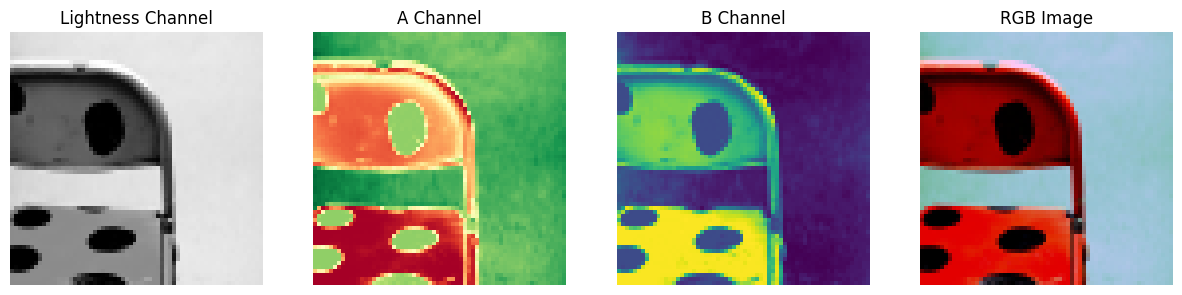

In [4]:
l, ab = next(iter(train_loader))

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(l[0].squeeze().cpu(), cmap="gray")
ax[0].set_title("Lightness Channel")
ax[0].set_axis_off()

ax[1].imshow(ab[0,0].cpu(), cmap="RdYlGn_r")
ax[1].set_title("A Channel")
ax[1].set_axis_off()

ax[2].imshow(ab[0, 1].cpu())
ax[2].set_title("B Channel")
ax[2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].cpu().numpy(), ab[0].cpu().numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[3].imshow(rgb, interpolation=None)
ax[3].set_title("RGB Image")
ax[3].set_axis_off()

In [5]:
class BaseModel(nn.Module):
	def __init__(self):
		super(BaseModel, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [6]:
class ImageColorizerModel(BaseModel):
    def __init__(self, classes=529):
        super(ImageColorizerModel, self).__init__()

        # Conv1
        self.model1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
        )

        # Conv2
        self.model2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
        )

        # Conv3
        self.model3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
        )

        # Conv4
        self.model4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv5
        self.model5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv6
        self.model6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv7
        self.model7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(512),
        )

        # Conv7
        self.model8up = nn.Upsample(scale_factor=2) #nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)
        self.model8 = nn.Sequential(
            #nn.ReLU(True),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
        )

        # Conv9
        self.model9up = nn.Upsample(scale_factor=2) #nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)
        self.model9 = nn.Sequential(
            #nn.ReLU(True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
        )

        # Conv10
        self.model10up = nn.Upsample(scale_factor=2) #nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True)
        self.model10 = nn.Sequential(
            #nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=True),
            nn.LeakyReLU(negative_slope=.2),
        )

        # regression output
        self.model_out = nn.Sequential(
            nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True),
            nn.Tanh()
        )
        
    def forward(self, X):

        conv1 = self.model1(X)
        conv2 = self.model2(conv1[:,:,::2,::2])
        conv3 = self.model3(conv2[:,:,::2,::2])
        conv4 = self.model4(conv3[:,:,::2,::2])
        conv5 = self.model5(conv4)
        conv6 = self.model6(conv5)
        conv7 = self.model7(conv6)

        conv8_up = self.model8up(conv7)
        conv8 = self.model8(conv8_up)
        conv9_up = self.model9up(conv8)
        conv9 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9)
        conv10 = self.model10(conv10_up)
        out_reg = self.model_out(conv10)
        
        return self.unnormalize_ab(out_reg)


In [7]:
from torchinfo import summary

model = ImageColorizerModel()
summary(model, input_size=(batch_size, 1, 64, 64), col_names=["input_size", "output_size", "num_params", "kernel_size",], depth=5)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ImageColorizerModel                      [128, 1, 64, 64]          [128, 2, 64, 64]          --                        --
├─Sequential: 1-1                        [128, 1, 64, 64]          [128, 64, 64, 64]         --                        --
│    └─Conv2d: 2-1                       [128, 1, 64, 64]          [128, 64, 64, 64]         640                       [3, 3]
│    └─ReLU: 2-2                         [128, 64, 64, 64]         [128, 64, 64, 64]         --                        --
│    └─Conv2d: 2-3                       [128, 64, 64, 64]         [128, 64, 64, 64]         36,928                    [3, 3]
│    └─ReLU: 2-4                         [128, 64, 64, 64]         [128, 64, 64, 64]         --                        --
│    └─BatchNorm2d: 2-5                  [128, 64, 64, 64]         [128, 64, 64, 64]         128                       --
├─Sequ

In [8]:
from tqdm import tqdm
from IPython.display import clear_output

model = ImageColorizerModel().to(device)

train_losses = []

lr = 5e-5
epochs = 64
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_loop(train_loader, model, loss_fn, optimizer, epoch):
    size = len(train_loader.dataset)
    for batch, (X, y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred.to(device), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * len(X)

        train_losses.append(loss)

        clear_output(wait=True)
        plt.figure(figsize=(16, 8))
        plt.plot(train_losses)
        plt.title(f"Epoch {epoch} Batch {batch}/{len(train_loader)} Loss {loss:.2f}")
        plt.xlabel("Cumulative Batch")
        plt.ylabel("Loss")
        plt.ylim(0, 2000)
        plt.show()

        # if batch % 50 == 0:
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
        
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

    lab = np.concatenate((X[0].cpu().numpy(), pred[0].cpu().numpy()), axis=0).transpose(1, 2, 0)
    rgb = color.lab2rgb(lab)

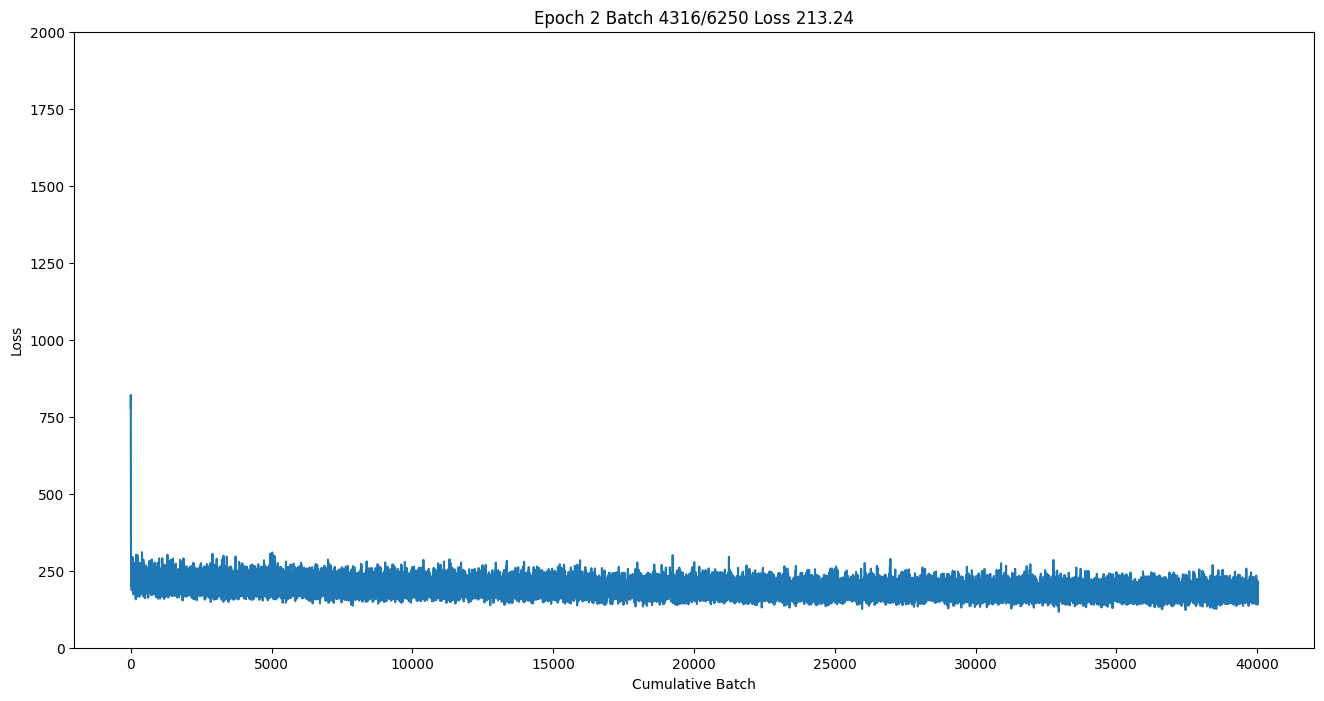

: 

: 

In [22]:
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, t)
    test_loop(test_loader, model, loss_fn)

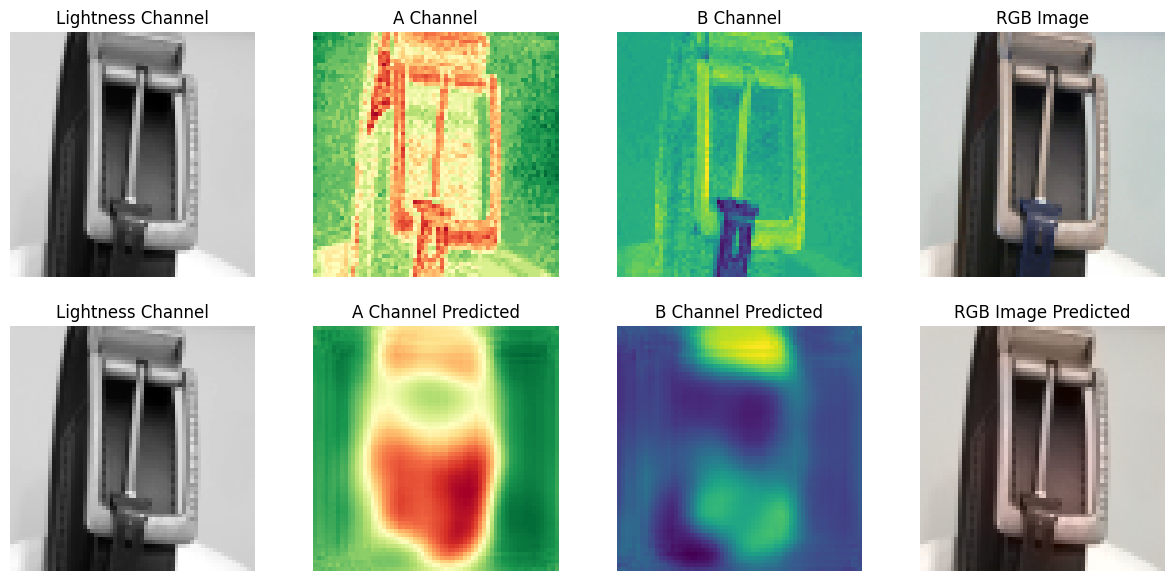

In [21]:
l, ab = next(iter(test_loader))

fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(l[0].squeeze().cpu(), cmap="gray")
ax[0, 0].set_title("Lightness Channel")
ax[0, 0].set_axis_off()

ax[0, 1].imshow(ab[0,0].cpu(), cmap="RdYlGn_r")
ax[0, 1].set_title("A Channel")
ax[0, 1].set_axis_off()

ax[0, 2].imshow(ab[0, 1].cpu())
ax[0, 2].set_title("B Channel")
ax[0, 2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].cpu().numpy(), ab[0].cpu().numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[0, 3].imshow(rgb, interpolation=None)
ax[0, 3].set_title("RGB Image")
ax[0, 3].set_axis_off()

ab_hat = model(l.to(device)).detach().cpu().numpy()
lab_hat = np.concatenate((l[0].cpu().numpy(), ab_hat[0]), axis=0).transpose(1, 2, 0)
rgb_hat = color.lab2rgb(lab_hat)

ax[1, 0].imshow(l[0].squeeze().cpu(), cmap="gray")
ax[1, 0].set_title("Lightness Channel")
ax[1, 0].set_axis_off()

ax[1, 1].imshow(ab_hat[0,0], cmap="RdYlGn_r")
ax[1, 1].set_title("A Channel Predicted")
ax[1, 1].set_axis_off()

ax[1, 2].imshow(ab_hat[0, 1])
ax[1, 2].set_title("B Channel Predicted")
ax[1, 2].set_axis_off()

ax[1, 3].imshow(rgb_hat, interpolation=None)
ax[1, 3].set_title("RGB Image Predicted")
ax[1, 3].set_axis_off()